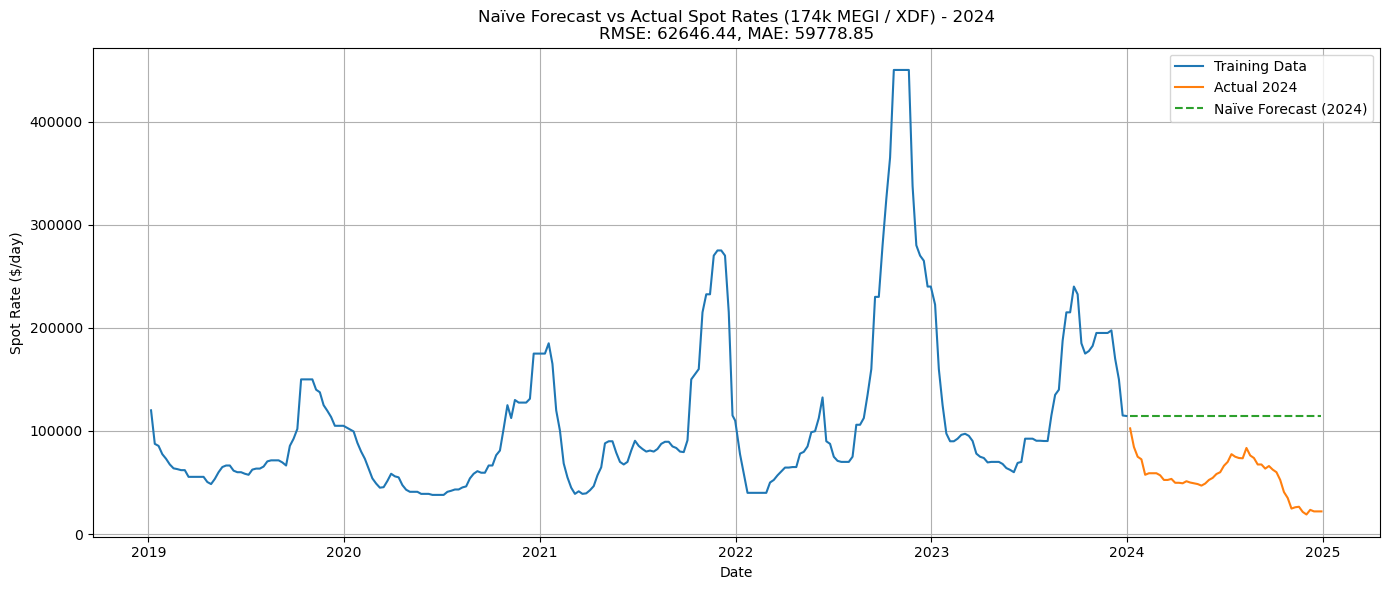

(62646.44381828008, 59778.846153846156)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Run the full naive forecast script now that the user re-entered it correctly

# Load the dataset
df = pd.read_csv("Spot charter rates - Fearnley LNG csv.csv", delimiter=';')
df.columns = df.columns.str.strip()
df['Date'] = pd.to_datetime(df['Date'].str.strip(), format="%d.%m.%Y")
df['174k MEGI / XDF'] = df['174k MEGI / XDF'].str.replace(' ', '').astype(float)
df = df.sort_values('Date')

# Split into training and test sets
train_data = df[df['Date'] < '2024-01-01'].copy()
test_data = df[(df['Date'] >= '2024-01-01') & (df['Date'] <= '2024-12-31')].copy()

# Naïve forecast: repeat last value of 2023 for all of 2024
last_value_2023 = train_data['174k MEGI / XDF'].iloc[-1]
naive_forecast = pd.Series(last_value_2023, index=test_data.index)

# Evaluate forecast
naive_rmse = np.sqrt(mean_squared_error(test_data['174k MEGI / XDF'], naive_forecast))
naive_mae = mean_absolute_error(test_data['174k MEGI / XDF'], naive_forecast)

# Plot forecast vs actual
plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], train_data['174k MEGI / XDF'], label='Training Data')
plt.plot(test_data['Date'], test_data['174k MEGI / XDF'], label='Actual 2024')
plt.plot(test_data['Date'], naive_forecast, label='Naïve Forecast (2024)', linestyle='--')
plt.title(f'Naïve Forecast vs Actual Spot Rates (174k MEGI / XDF) - 2024\nRMSE: {naive_rmse:.2f}, MAE: {naive_mae:.2f}')
plt.xlabel('Date')
plt.ylabel('Spot Rate ($/day)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

naive_rmse, naive_mae


C:\Users\Eier\AppData\Local\Temp\ipykernel_26056\1478573313.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  megi_xdf = df['174k MEGI / XDF'].dropna().resample('M').mean()


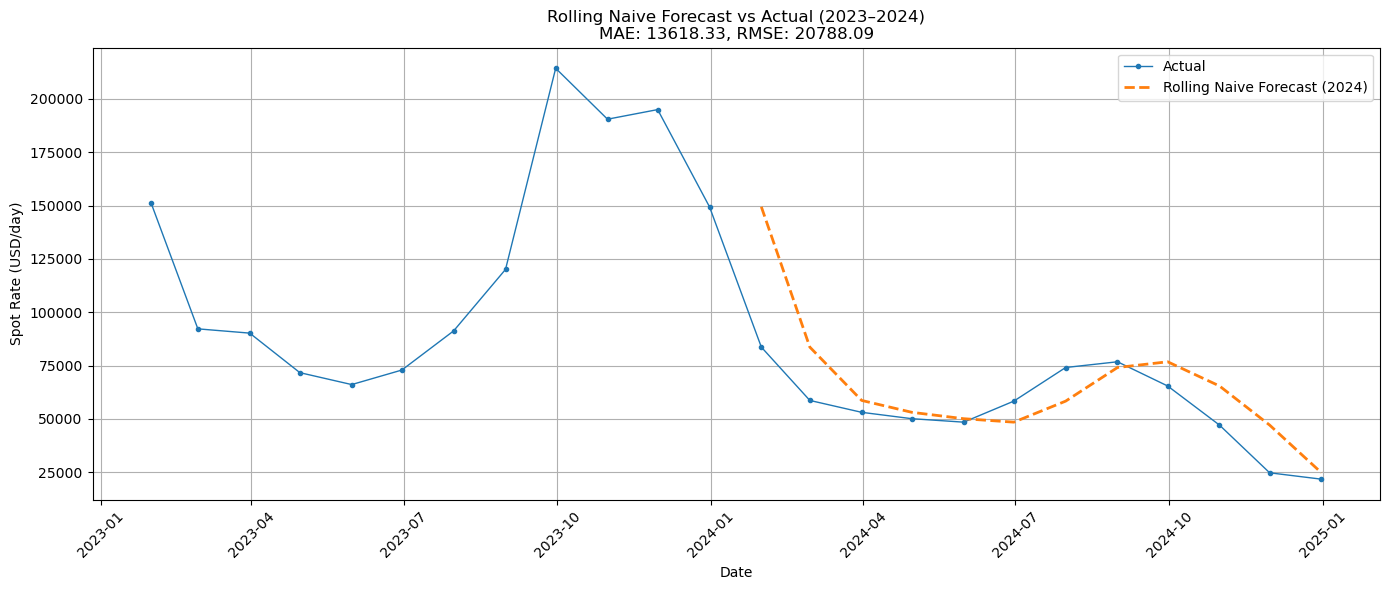

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Load Excel data ===
xls = pd.ExcelFile("Spot charter rates - Fearnley LNG.xlsx")
df = xls.parse('Export')

# === Parse and format ===
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# === Extract and resample to monthly ===
megi_xdf = df['174k MEGI / XDF'].dropna().resample('M').mean()

# === Split into train/test ===
train = megi_xdf[megi_xdf.index < '2024-01-01']
test = megi_xdf[megi_xdf.index >= '2024-01-01']

# === Rolling naive forecast ===
rolling_forecast = []
history = train.copy()

for date in test.index:
    forecast_value = history.iloc[-1]  # last known value
    rolling_forecast.append(forecast_value)
    history.loc[date] = test.loc[date]  # update history with actual

# === Evaluate forecast ===
mae_rolling = mean_absolute_error(test, rolling_forecast)
rmse_rolling = np.sqrt(mean_squared_error(test, rolling_forecast))

# === Plotting (from 2023 to 2024) ===
subset_plot = megi_xdf[(megi_xdf.index >= '2023-01-01') & (megi_xdf.index <= '2024-12-31')]
rolling_forecast_series = pd.Series(rolling_forecast, index=test.index)
rolling_forecast_trimmed = rolling_forecast_series[rolling_forecast_series.index <= '2024-12-31']

plt.figure(figsize=(14, 6))
plt.plot(subset_plot.index, subset_plot, label='Actual', marker='o', markersize=3, linewidth=1)
plt.plot(rolling_forecast_trimmed.index, rolling_forecast_trimmed, label='Rolling Naive Forecast (2024)', linestyle='--', linewidth=2)
plt.title(f"Rolling Naive Forecast vs Actual (2023–2024)\nMAE: {mae_rolling:.2f}, RMSE: {rmse_rolling:.2f}")
plt.xlabel("Date")
plt.ylabel("Spot Rate (USD/day)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
